## Dependencies

In [1]:
import json, warnings, shutil, glob
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

In [2]:
# Datasets
def get_training_dataset(x_train, y_train, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 
                                                   'attention_mask': x_train[1]}, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=SEED)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 
                                                   'attention_mask': x_valid[1]}, y_valid))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test[0], 
                                                  'attention_mask': x_test[1]})
    dataset = dataset.batch(batch_size)
    return dataset

## TPU configuration

In [3]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Mixed precision
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
# XLA
tf.config.optimizer.set_jit(True)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [4]:
database_base_path = '/kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-4/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])

print('Train set samples: %d' % len(k_fold))
print('Validation set samples: %d' % len(valid_df))
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-4/fold_1.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-4/fold_2.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-4/fold_3.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-4/fold_4.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192-ratio-4/fold_5.tar.gz

Train set samples: 668050
Validation set samples: 8000


,index,comment_text,toxic,toxic_int,fold_1,fold_2,fold_3,fold_4,fold_5
0,244991,"They have to have SOME justification for ""free...",0.000000,0,train,train,train,validation,train
1,1343581,"Completely untrue, he's an equal opportunity R...",0.600000,1,validation,train,train,train,train
2,91119,"""\n\nAm I supposed to be scared? It's not like...",1.000000,1,train,validation,train,train,train
3,525107,You realize this isn't a partisan issue right?...,0.741259,1,validation,train,train,train,train
4,714903,How many past and present U of O and 4J employ...,0.000000,0,validation,train,train,train,train


fold_1/
fold_1/x_train.npy
fold_1/y_valid.npy
fold_1/y_train.npy
fold_1/x_valid.npy


# Model parameters

In [5]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 128,
  "EPOCHS": 5,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [6]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    last_hidden_state, _= base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    cls_token = last_hidden_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', dtype='float32', name='output')(cls_token)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').astype(np.float32)
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy').astype(np.float32)
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']
    
    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True, verbose=1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        
    history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO),
                        validation_data=(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO)),
                        callbacks=[checkpoint, es],
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        verbose=2).history
        
    history_list.append(history)
    
    # Fine-tune on validation set
    print('\nFine-tune on validation set')
    n_steps2 = x_valid_ml.shape[1] // config['BATCH_SIZE']

    history2 = model.fit(get_training_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO),
                         steps_per_epoch=n_steps2,
#                          epochs=config['EPOCHS'],
                         epochs=2,
                         verbose=2).history
    
    # Make predictions
#     train_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_train.npy'), config['BATCH_SIZE'], AUTO))
#     valid_preds = model.predict(get_test_dataset(np.load(base_data_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
#     valid_ml_preds = model.predict(get_test_dataset(np.load(database_base_path + 'x_valid.npy'), config['BATCH_SIZE'], AUTO))
    
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
#     k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
#     valid_df['pred_%d' % (n_fold+1)] = np.round(valid_ml_preds)


FOLD: 1
Train for 4175 steps, validate for 62 steps
Epoch 1/5

Epoch 00001: val_loss improved from inf to 0.43544, saving model to model_fold_1.h5
4175/4175 - 1883s - loss: 0.4733 - binary_accuracy: 0.6404 - auc: 0.5448 - val_loss: 0.4354 - val_binary_accuracy: 0.8459 - val_auc: 0.5000
Epoch 2/5

Epoch 00002: val_loss improved from 0.43544 to 0.43536, saving model to model_fold_1.h5
4175/4175 - 1719s - loss: 0.4847 - binary_accuracy: 0.6394 - auc: 0.4991 - val_loss: 0.4354 - val_binary_accuracy: 0.8459 - val_auc: 0.5000
Epoch 3/5

Epoch 00003: val_loss did not improve from 0.43536
Restoring model weights from the end of the best epoch.
4175/4175 - 1728s - loss: 0.4844 - binary_accuracy: 0.6395 - auc: 0.4993 - val_loss: 0.4389 - val_binary_accuracy: 0.8459 - val_auc: 0.5000
Epoch 00003: early stopping

Fine-tune on validation set
Train for 62 steps
Epoch 1/2
62/62 - 102s - loss: 0.4339 - binary_accuracy: 0.8448 - auc: 0.5210
Epoch 2/2
62/62 - 25s - loss: 0.4341 - binary_accuracy: 0.845

## Model loss graph

Fold: 1


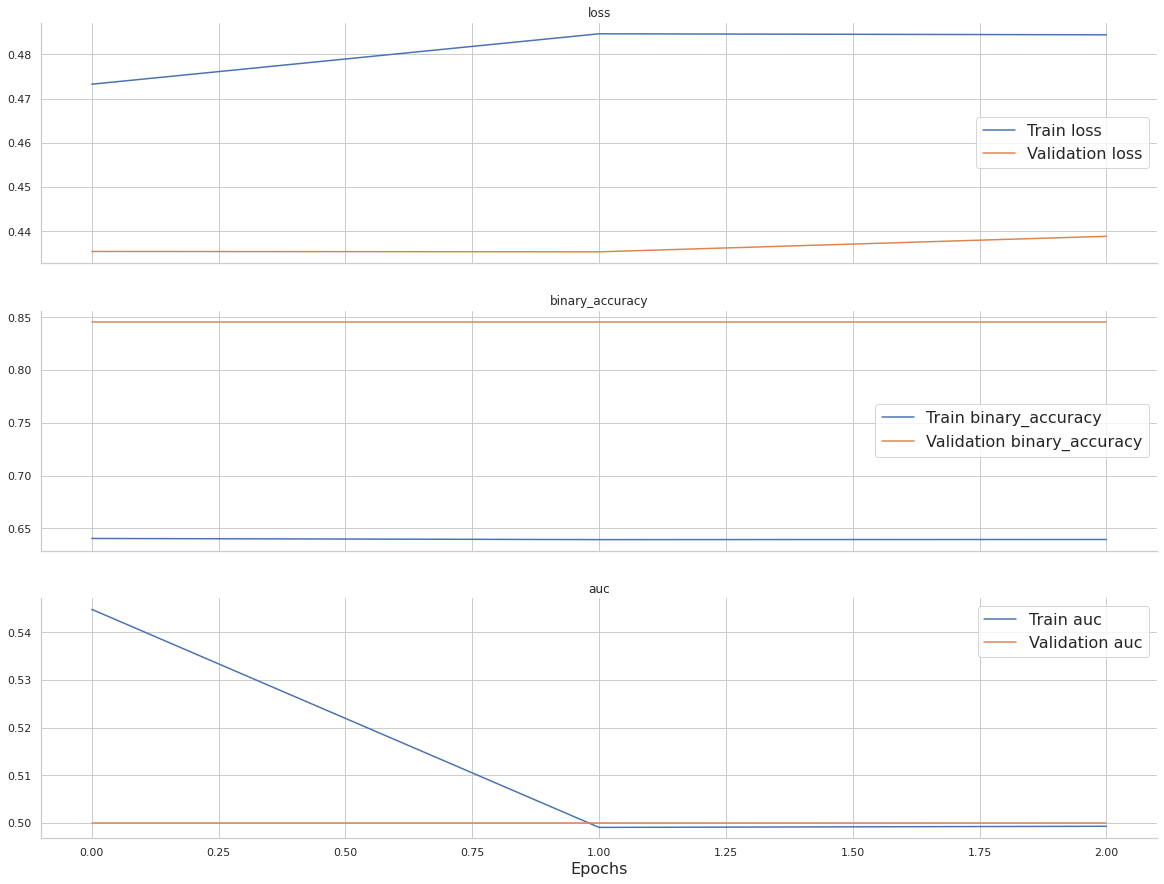

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
# display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

# Confusion matrix

In [10]:
# for n_fold in range(config['N_FOLDS']):
#     print('Fold: %d' % (n_fold+1))
#     train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
#     validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
#     plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
#                           validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [11]:
# display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
print('English validation set')
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

print('Multilingual validation set')
display(valid_df[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(10))

English validation set


,comment_text,toxic
0,"They have to have SOME justification for ""freely"" adopting celibacy ... are allegedly adopting celibacy. Otherwise ...",0.000000
1,"Completely untrue, he's an equal opportunity RACIST whom even hates whitey. We all know Trump represents no single r...",0.600000
2,"""\n\nAm I supposed to be scared? It's not like I can't just change my IP if I wanted to """"vandalize"""" my own user pa...",1.000000
3,You realize this isn't a partisan issue right? BOTH dems and republicans do this shit constantly. Instead of blaming...,0.741259
4,"How many past and present U of O and 4J employees live in 97405 ? Then ""they"" wonder why I call the U of O an activi...",0.000000
5,"Exactly why the Con party are in opposition, and with stupid comments like this one, they will be there for a very l...",0.757143
6,Bill Walker thinks he is right and that is the problem. He has never given up on the idea that he is right about the...,0.000000
7,And Rachael Stevenson the racist.,0.833333
8,This rag ceased to need reporters a few years back when it switched from being a news outlet to a feminist advocacy ...,0.000000
9,Bullexcrement. The report shows that there is a lot of money there to tax. Just because it is diluted with cannery w...,0.000000


Multilingual validation set


,comment_text,toxic
0,Este usuario ni siquiera llega al rango de hereje . Por lo tanto debería ser quemado en la barbacoa para purifi...,0
1,"Il testo di questa voce pare esser scopiazzato direttamente da qui. Immagino possano esserci problemi di copyright, ...",0
2,"Vale. Sólo expongo mi pasado. Todo tiempo pasado fue mejor, ni mucho menos, yo no quisiera retroceder 31 años a nive...",1
3,Bu maddenin alt başlığı olarak uluslararası ilişkiler ile konuyu sürdürmek ile ilgili tereddütlerim var.Önerim siy...,0
4,Belçika nın şehirlerinin yanında ilçe ve beldelerini yaparken sanırım Portekizi örnek alacaksın. Ben de uzak gelecek...,0
5,"güzel, zaten kaynaklandırması zor subjektif kategoriler bunlar. bazı maddelerden çıkartmak, kiminden çıkartıp kimind...",0
6,"No es mala idea. De hecho, yo estaba pensando descolgarme ya del reto mensual, pero esto vuelve a ilusionarme. El pr...",0
7,"Kod hatalarını düzeltmişsiniz,elinize sağlık çok teşekkürler.Önceki sürümleri araştırdım.13 Haziran 2010 da Kullanıc...",0
8,Levent Abi nasılsın? Hayat nasıl gidiyor? Umarım her şey istediğin gibidir. Bu arada Janet Jackson maddesi seçkin ma...,0
9,"Creo que es importante que podamos reconocer a gente como Victor Manuel Vucetich , quien es originario de Tampico y ...",0


# Test set predictions

In [13]:
model_path_list = glob.glob('/kaggle/working/' + '*.h5')
model_path_list.sort()
print('Models to predict:')
print(*model_path_list, sep = "\n")

Models to predict:
/kaggle/working/model_fold_1.h5


In [14]:
x_test = np.load(database_base_path + 'x_test.npy')
NUM_TEST_IMAGES = x_test.shape[1]
test_preds = np.zeros((NUM_TEST_IMAGES, 1))

for model_path in model_path_list:
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(model_path)
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        model.load_weights(model_path)

    test_preds += model.predict(get_test_dataset(x_test, config['BATCH_SIZE'], AUTO)) / len(model_path_list)

/kaggle/working/model_fold_1.h5


In [15]:
submission = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')
submission['toxic'] = test_preds
submission.to_csv('submission.csv', index=False)

display(submission.describe())
display(submission.head(10))

,id,toxic
count,63812.000000,63812.000000
mean,31905.500000,0.194827
std,18421.082026,0.000016
min,0.000000,0.194755
25%,15952.750000,0.194816
50%,31905.500000,0.194827
75%,47858.250000,0.194838
max,63811.000000,0.194913


,id,toxic
0,0,0.194821
1,1,0.194801
2,2,0.194817
3,3,0.194860
4,4,0.194856
5,5,0.194829
6,6,0.194835
7,7,0.194800
8,8,0.194800
9,9,0.194827
